# Get Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/PlantSnap/images.zip

Archive:  /content/drive/MyDrive/PlantSnap/images.zip
   creating: images/daisy/
  inflating: images/daisy/100080576_f52e8ee070_n.jpg  
  inflating: images/daisy/10140303196_b88d3d6cec.jpg  
  inflating: images/daisy/10172379554_b296050f82_n.jpg  
  inflating: images/daisy/10172567486_2748826a8b.jpg  
  inflating: images/daisy/10172636503_21bededa75_n.jpg  
  inflating: images/daisy/102841525_bd6628ae3c.jpg  
  inflating: images/daisy/10300722094_28fa978807_n.jpg  
  inflating: images/daisy/1031799732_e7f4008c03.jpg  
  inflating: images/daisy/10391248763_1d16681106_n.jpg  
  inflating: images/daisy/10437754174_22ec990b77_m.jpg  
  inflating: images/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: images/daisy/10437929963_bc13eebe0c.jpg  
  inflating: images/daisy/10466290366_cc72e33532.jpg  
  inflating: images/daisy/10466558316_a7198b87e2.jpg  
  inflating: images/daisy/10555749515_13a12a026e.jpg  
  inflating: images/daisy/10555815624_dc211569b0.jpg  
  inflating: images/daisy/1055

# Data Split

In [3]:
!pip install split-folders

In [4]:
import splitfolders
splitfolders.ratio('/content/images', output="split_images", seed=1337, ratio=(.8,.1,.1))

Copying files: 4327 files [00:02, 1868.02 files/s]


# Import Library

In [5]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import cv2
import pathlib
import pandas as pd
from tensorflow.keras.applications import DenseNet201, MobileNetV2, VGG16, EfficientNetB5, InceptionV3, EfficientNetV2M, EfficientNetV2B0, EfficientNetB7, DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from keras.layers import Input
from keras import layers
from tensorflow.keras.preprocessing import image
from PIL import Image
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model

# Image PreProcessing

In [6]:
base_dir = '/content/split_images'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [7]:
class_names = sorted(os.listdir('/content/split_images/train'))
n_classes = len(class_names)

# Print
print("No. Classes : {}".format(n_classes))
print("Classes     : {}".format(class_names))

No. Classes : 5
Classes     : ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [8]:
batch_size = 16


#train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_datagen = ImageDataGenerator(
                    rescale=1/255.,
                    rotation_range = 40,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True)

val_datagen = ImageDataGenerator(
                    rescale=1./255)

test_datagen = ImageDataGenerator(
                    rescale=1./255)


train_dataset = train_datagen.flow_from_directory(
        train_dir,
        shuffle=True,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

val_dataset = val_datagen.flow_from_directory(
        val_dir,
        shuffle=False,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_dataset = val_datagen.flow_from_directory(
        test_dir,
        shuffle=False,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 3460 images belonging to 5 classes.
Found 431 images belonging to 5 classes.
Found 436 images belonging to 5 classes.


# Show Random Image

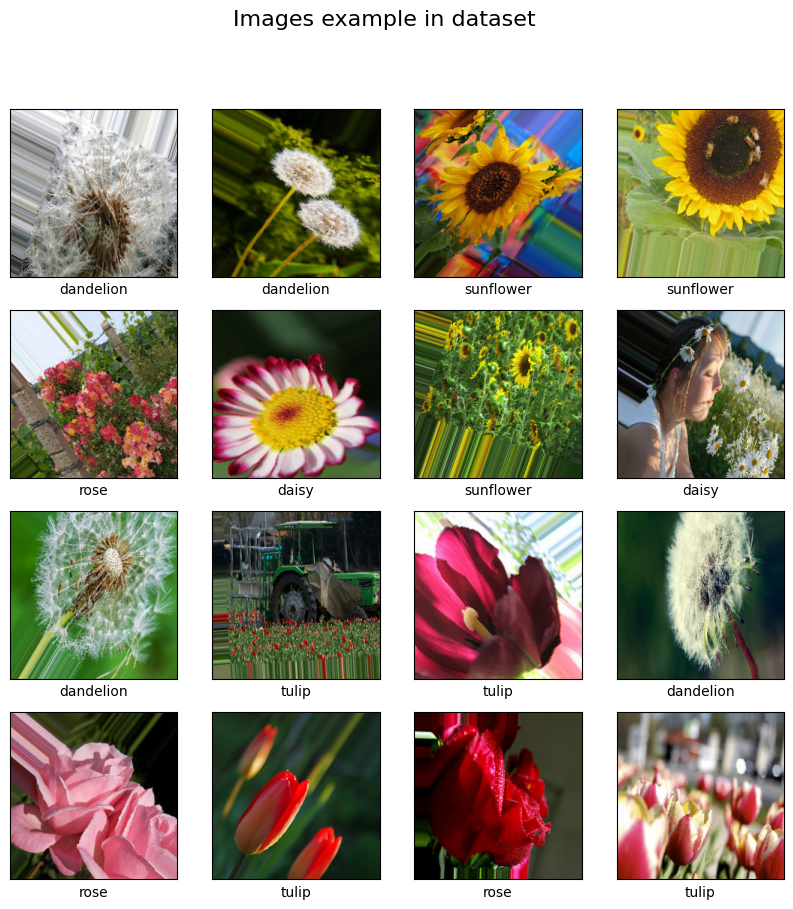

In [9]:
x,y = train_dataset.next()

label = np.argmax(y, axis=1)
fig = plt.figure(figsize=(10,10))
fig.suptitle("Images example in dataset", fontsize=16)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[label[i]])
plt.show()

# Transfer Learning using DenseNet121

In [10]:
pre_trained_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

29084464/29084464 [==============================] - 0s 0us/step


# Fine Tuning

In [11]:
freeze_index = None
for i,layer in enumerate(pre_trained_model.layers):
    if 'conv4' in layer._name:
        freeze_index = i
        break

for layer in pre_trained_model.layers[:freeze_index]:
    layer.trainable = False

In [12]:
x = pre_trained_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = tf.keras.models.Model(pre_trained_model.input, outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']      

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [14]:
checkpointer = ModelCheckpoint(filepath='model/best_model_densenet121.h5', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=2,
    verbose=1,
    mode='max',
    min_lr=0.000001
)

# Training Model

In [15]:
num_epochs = 10
start_time = time.time()

history = model.fit(train_dataset,
                epochs=num_epochs,
                validation_data=val_dataset,
                callbacks=[checkpointer, reduce_lr])

elapsed_time = time.time() - start_time
time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

Epoch 1/10
217/217 [==============================] - ETA: 0s - loss: 0.7139 - accuracy: 0.7384
Epoch 1: val_loss improved from inf to 0.23794, saving model to model/best_model_densenet121.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


217/217 [==============================] - 138s 325ms/step - loss: 0.7139 - accuracy: 0.7384 - val_loss: 0.2379 - val_accuracy: 0.9211 - lr: 1.0000e-04
Epoch 2/10
217/217 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.8743
Epoch 2: val_loss improved from 0.23794 to 0.20869, saving model to model/best_model_densenet121.h5
217/217 [==============================] - 59s 272ms/step - loss: 0.3490 - accuracy: 0.8743 - val_loss: 0.2087 - val_accuracy: 0.9327 - lr: 1.0000e-04
Epoch 3/10
217/217 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9029
Epoch 3: val_loss improved from 0.20869 to 0.19426, saving model to model/best_model_densenet121.h5
217/217 [==============================] - 61s 282ms/step - loss: 0.2741 - accuracy: 0.9029 - val_loss: 0.1943 - val_accuracy: 0.9420 - lr: 1.0000e-04
Epoch 4/10
217/217 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9231
Epoch 4: val_loss improved from 0.19426 to 0.14087, saving

'00:12:37'

# Model Evaluation

In [16]:
model.evaluate(test_dataset,batch_size=16)
y_pred=model.predict(test_dataset)
y_pred=np.argmax(y_pred,axis=1)
accuracy_score(y_pred,test_dataset.classes)
print(classification_report(y_pred,test_dataset.classes))

28/28 [==============================] - 4s 52ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        74
           1       0.97      0.94      0.96       109
           2       0.97      0.93      0.95        83
           3       0.93      0.96      0.95        72
           4       0.94      0.95      0.94        98

    accuracy                           0.94       436
   macro avg       0.94      0.95      0.94       436
weighted avg       0.95      0.94      0.95       436



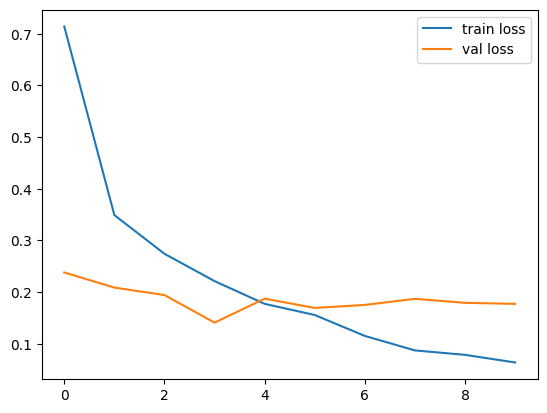

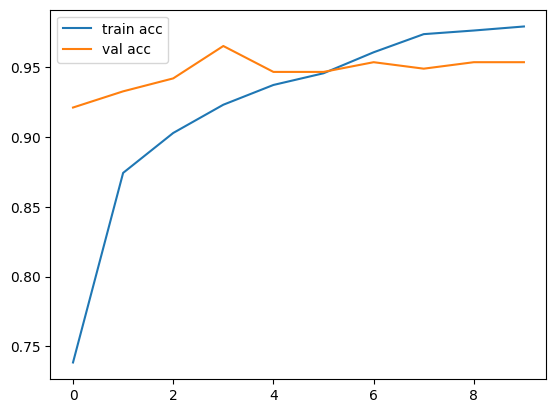

In [17]:
def report_train(history):
    # loss
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    # accuracies
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val acc')
    plt.legend()
    plt.show()

report_train(history)

# Testing model using new data

In [21]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.

    preds = model.predict(img)
    class_labels = class_names
    pred = np.argmax(preds, axis=-1)
    if show:
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(class_labels[pred[0]])
        plt.show()

1/1 [==============================] - 4s 4s/step


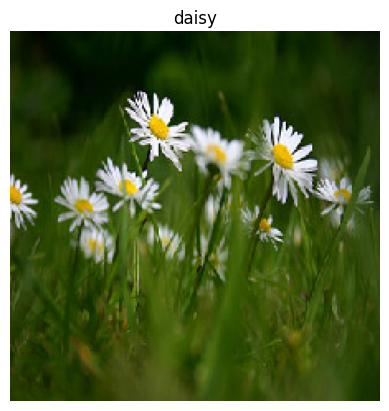

1/1 [==============================] - 0s 46ms/step


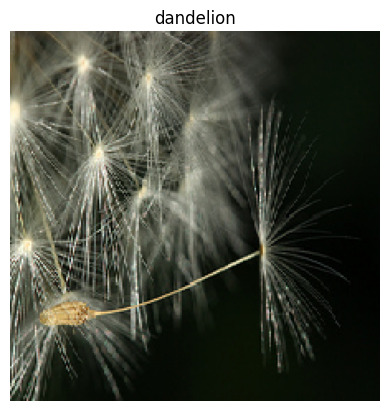

1/1 [==============================] - 0s 41ms/step


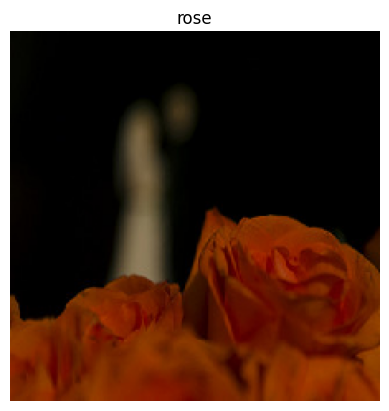

1/1 [==============================] - 0s 41ms/step


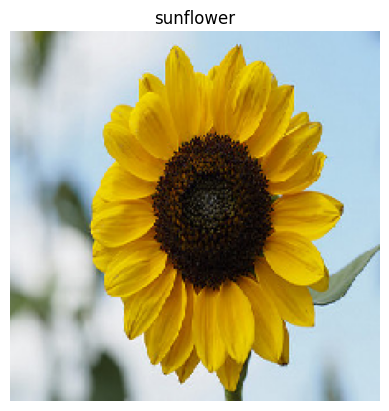

1/1 [==============================] - 0s 45ms/step


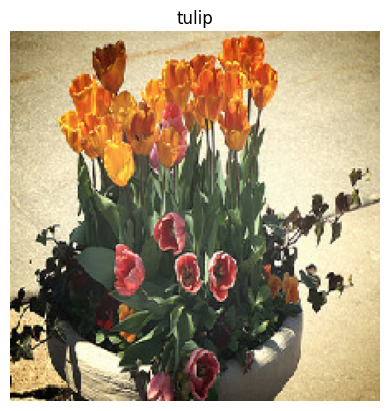

In [22]:
images = []

images.append('/content/split_images/test/daisy/105806915_a9c13e2106_n.jpg')
images.append('/content/split_images/test/dandelion/12998979765_3de89e7195_n.jpg')
images.append('/content/split_images/test/rose/14172324538_2147808483_n.jpg')
images.append('/content/split_images/test/sunflower/20407896403_a50fef58ac_n.jpg')
images.append('/content/split_images/test/tulip/14009216519_b608321cf2_n.jpg')

predict_class(model, images, show = True)

# Saving Model

In [18]:
export_dir = 'saved_model/PlantSnap_Model_densenet121/'
tf.saved_model.save(model, export_dir)

In [19]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [20]:
tflite_model_file = pathlib.Path('PlantSnap_Model_densenet121.tflite')
tflite_model_file.write_bytes(tflite_model)

29998708

# Save History

In [23]:
# Convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)
path = 'history/'

# Check if the directory exists, if not, create it
if not os.path.exists(path):
    os.makedirs(path)

# csv:
hist_csv_file = 'PlantSnap_Model_densenet121.csv'
with open(os.path.join(path, hist_csv_file), mode='w') as f:
    hist_df.to_csv(f, index=False)